In [63]:
import xgboost as xgb
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
pd.options.plotting.backend = 'plotly'

In [64]:
everything = pd.read_parquet('../data/everything_v2.parquet.gzip')

In [80]:
everything.head(15)

,date,price_diff_lag_1,price_diff_lag_2,price_diff_lag_3,day,hour,compound,price_diff
4,2021-03-16 15:00:00,1,0,2,16,15,0.063489,0
5,2021-03-16 18:00:00,0,1,0,16,18,0.032586,2
6,2021-03-16 21:00:00,2,0,1,16,21,0.094229,2
7,2021-03-17 00:00:00,2,2,0,17,0,0.117510,0
8,2021-03-17 03:00:00,0,2,2,17,3,0.162449,1
9,2021-03-17 06:00:00,1,0,2,17,6,0.076906,1
10,2021-03-17 09:00:00,1,1,0,17,9,0.076150,0
11,2021-03-17 12:00:00,0,1,1,17,12,0.070207,0
12,2021-03-17 15:00:00,0,0,1,17,15,0.167008,2
13,2021-03-17 18:00:00,2,0,0,17,18,0.093245,2


In [65]:
features_list = ['price_diff_lag_1', 'price_diff_lag_2', 'price_diff_lag_3', 'hour', 'day', 'compound']
target_list = ['price_diff']
features_df = everything[features_list]
target_df = everything[target_list]

In [66]:
features_df = features_df.rename(columns={'compound': 'sentiment_score'})

In [67]:
X, y = features_df, target_df.values.ravel()

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123)

In [69]:
params = {
    'min_child_weight': [1, 2, 3],
    'gamma': [0.5, 1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.3, 0.4],
    'max_depth': [2, 3, 4],
    'n_estimators': [50, 100]
}

In [70]:
xgb_regressor = xgb.XGBClassifier(
    learning_rate=0.02,
    objective='binary:logistic',
    eval_metric='error'
)

In [71]:
grid_search = GridSearchCV(
    xgb_regressor,
    param_grid=params,
    verbose=1
)

In [72]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
C:\Users\Andrew\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\Andrew\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

C:\Users\Andrew\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_labe

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric='error',
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.02, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
               

In [73]:
model = grid_search.best_estimator_

In [74]:
preds = model.predict(X_test)

C:\Users\Andrew\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



In [75]:
accuracy_score(y_test, preds)

0.7222222222222222

In [76]:
results = {
    'Predicted': preds,
    'Actual': y_test
}
results_df = pd.DataFrame.from_dict(results).reset_index(drop=True)

In [82]:
results_df.plot.bar(
    barmode='group',
    labels=dict(index='', value='Bitcoin Quantile', variable='Variable'),
    title='Bitcoin 3 Hour Quantile: Predicted vs Actual'
)

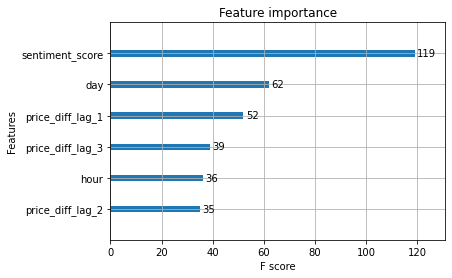

In [78]:
plot_importance(model)